<a href="https://colab.research.google.com/github/epereirasg/Curso-de-Machine-Learning/blob/main/S07-Linear-Models/Tarea_regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regresion Lineal aplicada a datos de automóviles

En esta tarea usted debe investigar acerca del conjunto de datos [auto mpg](https://seaborn.pydata.org/examples/scatter_bubbles.html) perteneciente a la libreria [seaborn](https://seaborn.pydata.org/)

**Objetivo**: Estimar el rendimiento promedio de automoviles usando regresión lineal

1) (1 punto) Establecer una visualización de los datos a través de un [Gráfico de dispersión](https://seaborn.pydata.org/tutorial/axis_grids.html)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


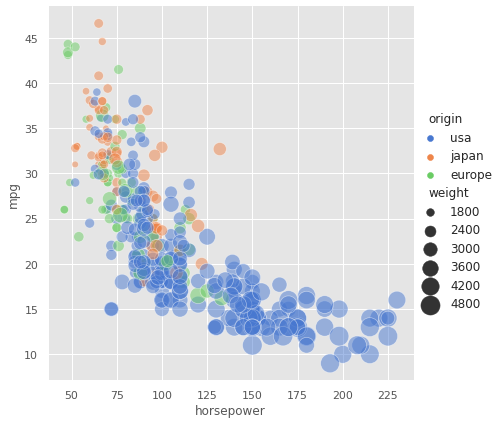

In [57]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")
mpg.info()


# Los gráficos de dispersión, también denominados diagramas de dispersión o scatter plots en la literatura en inglés, se utilizan para comparar los valores que toman dos variables distintas, una de las cuales se representa a lo largo del eje x y la otra a lo largo del eje y. 
# La gráfica resultante nos permite identificar visualmente la posible correlación entre las dos variables.

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=mpg)

In [58]:
# Controlando valores nulos, devuelve true si existen valores nulos
mpg.isnull().any().any()

True

El método nos devuelve el valor "True", lo que indica que existen valores nulos en nuestro dataset. Estos valores pueden tener una influencia significativa en nuestro modelo predictivo, por lo que siempre es una decisión importante determinar la forma en que los vamos a manejar.

In [70]:

# Agrupando columnas por tipo de datos
tipos = mpg.columns.to_series().groupby(mpg.dtypes).groups

# Armando lista de columnas categóricas
ctext = tipos[np.dtype('object')]
len(ctext)  # cantidad de columnas con datos categóricos.

# Armando lista de columnas numéricas
columnas = mpg.columns  # lista de todas las columnas
cnum = list(set(columnas) - set(ctext))
len(cnum)

# Completando valores faltantas datos cuantititavos, para lo que utilizaremos la media.
for c in cnum:
    mean = mpg[c].mean()
    mpg[c] = mpg[c].fillna(mean)

# Completando valores faltantas datos categóricos, para lo que utilizaremos la moda
for c in ctext:
    mode = mpg[c].mode()[0]
    mpg[c] = mpg[c].fillna(mode)




In [71]:
# Controlando que no hayan valores faltantes, si devuelve false nos aseguramos de que no existen valores faltantes.
mpg.isnull().any().any()

False

In [74]:
# Ahora veamos algunas estadísticas de nuestros datos
mpg.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


2) (1 punto) Investigar e incluir un grafico de correlacion ([Correlation Plot](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)) para visualizar la dependencia entre los datos 

Para poder elegir el coeficiente de correlación adecuado, se tiene que analizar el tipo de variables y la distribución que presentan. En este caso ocuparemos las variables horsepower y displacement, ambas variables son cuantitativas continuas y pueden ordenarse para convertirlas en un ranking. La elección se hará en función de la distribución que presenten las observaciones: normalidad, homocedasticidad y presencia de outliers.

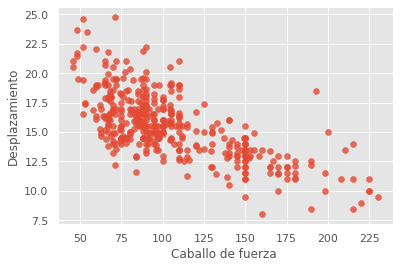

In [72]:

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=mpg.horsepower , y=mpg.acceleration, alpha= 0.8)
ax.set_xlabel('Caballo de fuerza ')
ax.set_ylabel('Desplazamiento');




In [73]:
from scipy.stats import pearsonr
# Correlación lineal entre las dos variables
# ==============================================================================
corr_test = pearsonr(x = mpg['horsepower'], y = mpg['displacement'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.8936462355336694
P-value:  7.138674560791448e-140


3) (1 punto) Construir y entrenar un modelo de regresion lineal


El gráfico y el test de correlación muestran una relación lineal, de intensidad considerable (r = 0.89) y significativa (p-value = 7.13867456). Tiene sentido intentar generar un modelo de regresión lineal con el objetivo de predecir el Desplazamiento  en función de los Caballos de fuerza que tiene el auto.

**Ajuste del Modelo**

Se ajusta un modelo empleando como variable respuesta Desplazamiento y como predictor caballos de Fuerza. Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

In [64]:
# División de los datos en train y test
# ==============================================================================
X = mpg[['horsepower']]
y = mpg['displacement']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)






LinearRegression()

In [65]:
# Información del modelo
# ==============================================================================
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X, y))

Intercept: [-57.63625104]
Coeficiente: [('horsepower', 2.3904067920760337)]
Coeficiente de determinación R^2: 0.7981173597165313


Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [66]:
# Error de test del modelo 
# ==============================================================================
predicciones = modelo.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[308.09598815]
 [360.68493758]
 [241.16459797]]

El error (rmse) de test es: 51.17431161393847


5) (1 punto) Mostrar [graficamente la lineas rectas](https://seaborn.pydata.org/tutorial/regression.html) en un grafico de dispersión para el par de variables que presentan la mayor correlacion. esta informacion la obtiene del correlation plot. realizar un grafico de dispersion con las variables mas correlacionadas.


6) (1 punto) [Guardar el Jupyter notebook resultante en su cuenta propia de Github ](https://bebi103a.github.io/lessons/02/git_with_colab.html) y compartir el enlace en la pagina de la tarea en Educandus.